In [2]:
%load_ext autoreload
%autoreload 2

# Import Classes

In [3]:
import sys
import os


sys.path.append("..")

In [4]:
import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm


import torch

from src.utils import confoundSplit, confoundSplitNumbers, confoundSplitDF

from src.NeuralModel import TransformerDataset
from src.AdversarialModel import GradientReverseModel
from src.data_process import load_wls_adress_AddDomain

from sklearn.preprocessing import MultiLabelBinarizer

# Data

In [5]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

In [6]:
df_wls_merge['domain_index'].value_counts()

0    1360
Name: domain_index, dtype: int64

In [7]:
df_adress['domain_index'].value_counts()

1    548
Name: domain_index, dtype: int64

# (2/2: applying) Use Cross Entropy Loss: Apply

## Data

In [27]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

In [28]:
df_wls_merge['domain_index'].value_counts()

0    1360
Name: domain_index, dtype: int64

In [29]:
df_adress['domain_index'].value_counts()

1    548
Name: domain_index, dtype: int64

### Data Mix and Split

In [30]:
# combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)

combination = (0.201, 0.7010000000000001, 0.501, 1.4000000000000001, 4)
ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                      df0_label='label', df1_label='label',
                      p_pos_train_z0=combination[0], 
                      p_pos_train_z1 = combination[1], 
                      p_mix_z1 = combination[2], 
                      alpha_test = combination[3],
                      train_test_ratio = combination[4],
                      random_state=13
                           )

In [31]:

df_train = pd.concat([ret['sample_df0_train'][['text', 'label','domain_index']], ret['sample_df1_train'][['text', 'label','domain_index']]], ignore_index=True)


df_test = pd.concat([ret['sample_df0_test'][['text', 'label','domain_index']], ret['sample_df1_test'][['text', 'label','domain_index']]], ignore_index=True)

In [32]:
X_train = df_train['text']
y_train = df_train[['label']]
y_domain_train = df_train[['domain_index']]

X_test = df_test['text']
y_test = df_test[['label']]
y_domain_test = df_test[['domain_index']]

In [33]:
print(len(X_train))
print(len(y_train))
print(len(y_domain_train))

print(len(X_test))
print(len(y_test))
print(len(y_domain_test))

718
718
718
179
179
179


In [34]:
y_domain_train['domain_index'].value_counts()

0    359
1    359
Name: domain_index, dtype: int64

In [35]:
y_domain_test['domain_index'].value_counts()

0    90
1    89
Name: domain_index, dtype: int64

## Load Model

In [466]:
num_labels = 2

num_domain_labels = 2
# domain_labels = 'domain_index'

# pretrained = 'bert-base-uncased'
pretrained = "mental/mental-bert-base-uncased"
device = 'cuda:0'

max_length = 120
num_epochs = 7
problem_type = 'multi_label_classification'
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 50


lr = 5e-5
grad_norm = 1.0
balance_weights = False

grad_reverse=True

In [467]:

model_config = {}
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm
# model_config["domain_labels"] = ["domain"]
model_config["num_domain_labels"] = num_domain_labels
model_config["grad_reverse"] = grad_reverse

In [468]:
model = GradientReverseModel(**model_config)

In [469]:
model.load_pretrained()

## Test `trainModel()`

In [ ]:
random.seed(12)
np.random.seed(12)
torch.manual_seed(33)
torch.cuda.manual_seed(33)

model.trainModel(X=X_train, y=y_train,  y_domain=y_domain_train, device='cuda:0')

In [ ]:
random.seed(12)
np.random.seed(12)
torch.manual_seed(33)
torch.cuda.manual_seed(33)

model2.trainModel(X=X_train, y=y_train,  y_domain=y_domain_train, device='cuda:0')

## Test `trainModelWithTest()`

In [470]:
random.seed(21)
np.random.seed(21)
torch.manual_seed(19)
torch.cuda.manual_seed(19)


model.trainModelWithTest(X=X_train, y=y_train, y_domain_train=y_domain_train, X_test=X_test, y_test=y_test, y_domain_test=y_domain_test,
                         device='cuda:0')

100%|██████████| 105/105 [00:26<00:00,  3.99it/s]


In [471]:
import matplotlib.pyplot as plt

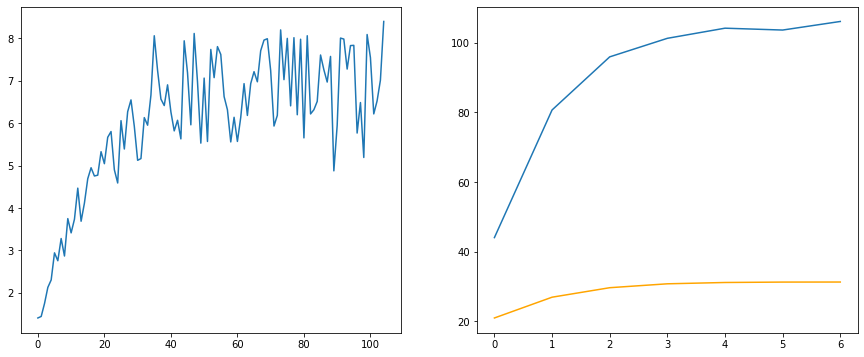

In [472]:
fig, ax = plt.subplots(1,2, figsize=(15, 6))

ax[0].plot(model.loss_steps)

ax[1].plot(model.loss_epochs)
ax[1].plot(model.loss_test_total_epochs, c='orange')


Text(0.5, 0.98, 'epoch=7, lr=5e-05')

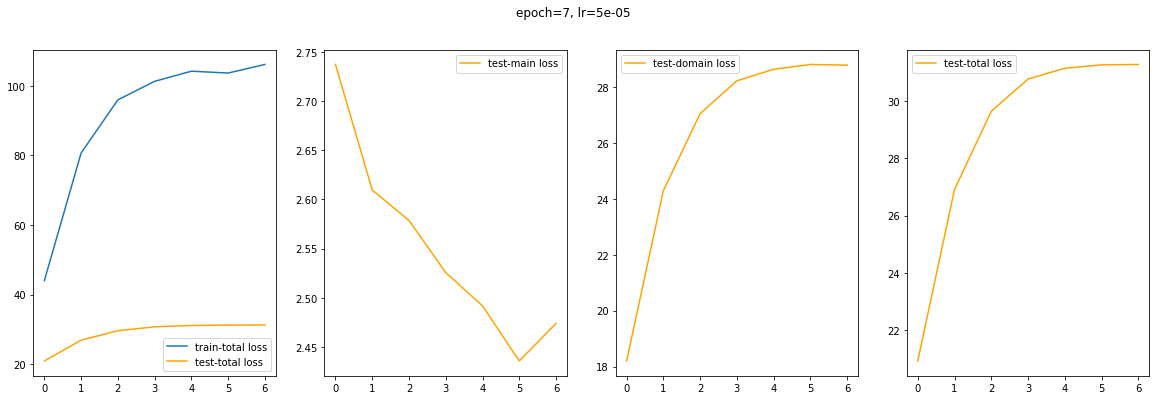

In [473]:
fig, ax = plt.subplots(1,4, figsize=(20, 6), sharex=True)

ax[0].plot(model.loss_epochs, label='train-total loss')
ax[0].plot(model.loss_test_total_epochs, c='orange', label='test-total loss')

ax[1].plot(model.loss_test_main_epochs, c='orange', label='test-main loss')
ax[2].plot(model.loss_test_domain_epochs, c='orange', label='test-domain loss')
ax[3].plot(model.loss_test_total_epochs, c='orange', label='test-total loss')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

fig.suptitle(f"epoch={num_epochs}, lr={lr}")



In [474]:
model.loss_test_total_epochs

[20.937690993130673,
 26.90894021735585,
 29.63491005657761,
 30.756790177817948,
 31.13513000726357,
 31.25157711505608,
 31.265858576294022]

In [475]:
model.loss_test_main_epochs

[2.7371811866760254,
 2.6096487641334534,
 2.5786489248275757,
 2.525660514831543,
 2.4918785095214844,
 2.43587726354599,
 2.4741140007972717]

Text(0.5, 1.0, 'epoch=7, lr=5e-05')

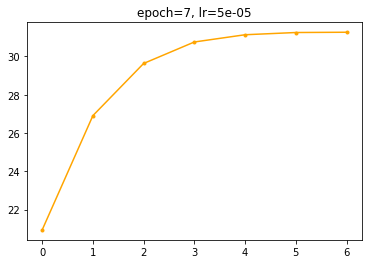

In [476]:
plt.plot(model.loss_test_total_epochs, c='orange', marker=".")
plt.title(f"epoch={num_epochs}, lr={lr}")

## Test `predict()`

In [ ]:
y_main_pred, y_main_prob, y_domain_pred, y_domain_prob = model.predict(X=X_test, device="cuda:0")



In [ ]:
y_main_prob

In [ ]:
loss = torch.nn.NLLLoss()

In [ ]:
loss(torch.log(torch.tensor(y_main_prob.values)), torch.tensor(y_test.values).squeeze(1))

In [ ]:
from sklearn import metrics

In [ ]:
y_main_prob

In [ ]:
target = np.random.randint(0,2,[10,3])
target

In [ ]:
m = torch.nn.Softmax(dim=1)

inputs = m(torch.rand(10,3))
inputs

In [ ]:
metrics.roc_auc_score(y_true=target, y_score=inputs)

In [ ]:
label_binarizer.transform([0,1,2,9])

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
reversed(range(2))

In [ ]:
multilabel_binarizer = MultiLabelBinarizer(classes=range(2))

In [ ]:
multilabel_binarizer.fit_transform(y_test.values)

In [ ]:
metrics.average_precision_score(y_true=multilabel_binarizer.fit_transform(y_test.values),
                      y_score=y_main_prob
                     )

In [ ]:
metrics.f1_score(y_true=y_test.values,
                      y_pred=y_main_pred
                     )

In [ ]:
df_wls_merge[['domain_WLS','domain_ADRESS']] = [1,0]

In [ ]:
df_adress[['domain_WLS','domain_ADRESS']] = [0,1]

In [ ]:

combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)
ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                            train_test_ratio = combination[4],
                           )

In [ ]:
ret

In [ ]:
combination = (0.201, 0.6010000000000001, 0.30100000000000005, 1.0, 4)
ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                            train_test_ratio = combination[4],
                           )

In [ ]:
ret['stats']

In [ ]:
ret

In [ ]:
df0_train = ret['sample_df0_train']

## Test Hidden Space

In [477]:
from torch.utils.data import DataLoader

In [478]:
dataset = TransformerDataset(
            X=X_test,
            pretrained=model.pretrained,
            max_length=model.max_length,
        )

dataloader = DataLoader(dataset, shuffle=False, batch_size=model.batch_size)


In [479]:
model.model.eval() 

_ls = []
for batch in dataloader:

    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs_bert = model.model.bert(input_ids=batch["input_ids"],
            token_type_ids=batch["token_type_ids"],
            attention_mask=batch["attention_mask"],)

        outputs_pooler = outputs_bert["pooler_output"]
        _ls.append(outputs_pooler.detach().cpu())

_ls = torch.concat(_ls)

In [480]:
_ls

tensor([[-0.8763,  0.7899, -0.6131,  ..., -0.8346,  0.7821, -0.8438],
        [-0.8769,  0.7911, -0.5845,  ..., -0.8186,  0.7862, -0.8360],
        [-0.8382,  0.7473, -0.5807,  ..., -0.7889,  0.7379, -0.8223],
        ...,
        [-0.8809,  0.8028, -0.5886,  ..., -0.8576,  0.8010, -0.8124],
        [-0.8929,  0.7740, -0.5913,  ..., -0.8614,  0.8282, -0.8168],
        [-0.8633,  0.7795, -0.5999,  ..., -0.8378,  0.7902, -0.8288]])

In [481]:
x_pooler = np.array(_ls)

In [482]:
x_pooler.dtype

dtype('float32')

In [483]:
np.array(x_pooler).shape

(179, 768)

In [488]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, 
                  init='random', 
                  perplexity=5,
                 ).fit_transform(x_pooler)
X_embedded.shape



(179, 2)

In [489]:
X_embeddings = pd.DataFrame(X_embedded)

X_embeddings['y_label'] = y_test.values

X_embeddings['y_domain_label'] = y_domain_test.values


<AxesSubplot:xlabel='0', ylabel='1'>

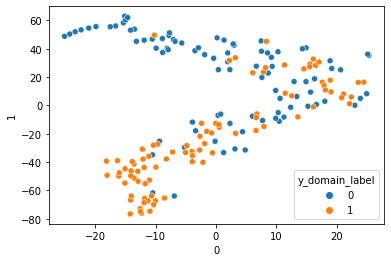

In [490]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=X_embeddings, x=0,y=1, hue='y_domain_label')

<AxesSubplot:xlabel='0', ylabel='1'>

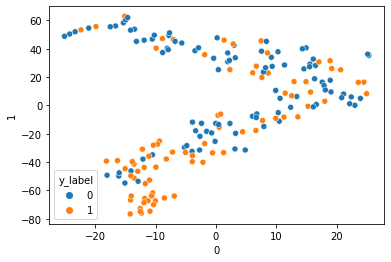

In [491]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=X_embeddings, x=0,y=1, hue='y_label')

In [493]:
import umap

In [495]:
fit = umap.UMAP()
u = fit.fit_transform(x_pooler)

In [496]:
X_embeddings = pd.DataFrame(u)

X_embeddings['y_label'] = y_test.values

X_embeddings['y_domain_label'] = y_domain_test.values


In [499]:
u.shape

(179, 2)

<AxesSubplot:xlabel='0', ylabel='1'>

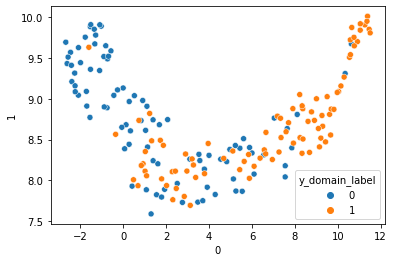

In [501]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=X_embeddings, x=0,y=1, hue='y_domain_label')

# Multiple Tests for mixing

## Model Config

In [20]:
num_labels = 2

num_domain_labels = 2
# domain_labels = 'domain_index'

pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 20
problem_type = 'multi_label_classification'
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 50


lr = 1e-5
grad_norm = 1.0
balance_weights = False



In [21]:

model_config = {}
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm
# model_config["domain_labels"] = ["domain"]
model_config["num_domain_labels"] = num_domain_labels

## 5 Random Runs: Train and Predict

### Get Combinations

In [22]:
n_test = 200  # the number of testing examples; set to None to disable (i.e., get as many examples as possible)
n_test_error = 0

valid_high_combinations = []
valid_full_settings = []
for combination in itertools.product([0.1], 
                                    [0.5], 
                                     np.arange(0.05, 0.99, 0.05),
                                     np.arange(0, 10, 0.1),
                                     [4],
                                     [n_test],
                                     [n_test_error]
                                    ):
    
    ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                        df0_label='label', df1_label='label',

                        p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                        train_test_ratio = combination[4], 
                               n_test=n_test, n_test_error=n_test_error
                       )
   
    if (ret is not None) and (ret['n_df0_train_pos'] >= 1): # valid high combos
        valid_high_combinations.append(combination)
        valid_full_settings.append(ret)
    

In [23]:
len(valid_high_combinations)

118

In [24]:
tmp = []
for s in valid_full_settings:
    tmp.append(s['n_df0_test_pos'] + s['n_df0_test_neg']  + s['n_df1_test_pos'] + s['n_df1_test_neg'])

In [25]:
_mix_z1 = [x[2] for x in valid_high_combinations]
print(min(_mix_z1))
print(max(_mix_z1))
print(sorted(set(_mix_z1)))

0.05
0.45
[0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35000000000000003, 0.4, 0.45]


In [26]:
tops = 2
valid_high_combinations = valid_high_combinations[:tops]
valid_full_settings = valid_full_settings[:tops]

### Run Train + Predict

In [ ]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['full_setting']=[]
losses_dict['losses'] = []
losses_dict['auroc'] = []
losses_dict['auprc'] = []
losses_dict['f1_at_05'] = []

random.seed(29)

for c,setting in tqdm(zip(valid_high_combinations, valid_full_settings), total=len(valid_high_combinations)):
    losses_dict['combination'].append(c)
    losses_dict['full_setting'].append(setting)
    
    losses = []
    _auroc = []
    _auprc = []    
    _f1_at_05 = []
    
    for i in range(5):
        _rand = random.randint(0,1000)    

        combination = c
        # combination = (0.201, 0.6, 0.3, 1.0, 4)
        # combination = (0.201, 0.7, 0.5, 1.4, 4)
        ret = confoundSplitDF(df0=df_wls_merge, df1=df_adress, 
                              df0_label='label', df1_label='label',
                              p_pos_train_z0=combination[0], 
                              p_pos_train_z1 = combination[1], 
                              p_mix_z1 = combination[2], 
                              alpha_test = combination[3],
                              train_test_ratio = combination[4],
                              random_state= _rand,
                              n_test=combination[5],
                              n_test_error=combination[6]
                                   )

        df_train = pd.concat(
                [
                    ret["sample_df0_train"][["text", "label", "domain_index"]],
                    ret["sample_df1_train"][["text", "label", "domain_index"]],
                ],
                ignore_index=True,
            )

        df_test = pd.concat(
                [
                    ret["sample_df0_test"][["text", "label", "domain_index"]],
                    ret["sample_df1_test"][["text", "label", "domain_index"]],
                ],
                ignore_index=True,
            )


        X_train = df_train["text"]
        y_train = df_train[["label"]]
        y_domain_train = df_train[["domain_index"]]

        X_test = df_test["text"]
        y_test = df_test[["label"]]
        y_domain_test = df_test[["domain_index"]]




        model = GradientReverseModel(**model_config)

        model.load_pretrained()

        model.trainModel(
                X=X_train, y=y_train, y_domain=y_domain_train, device="cuda:0"
            )



        y_main_pred, y_main_prob, y_domain_pred, y_domain_prob = model.predict(
                X=X_test, device="cuda:0"
            )

        

        # collect metrics: loss, auroc, auprc, f1
        loss = torch.nn.NLLLoss()

        _loss = loss(
            torch.log(torch.tensor(y_main_prob.values)),
            torch.tensor(y_test.values).squeeze(1),
        )

        losses.append(_loss.item())

        # num_domain_label
        multilabel_binarizer = MultiLabelBinarizer(classes=range(num_labels))

        _auroc.append(
            metrics.roc_auc_score(
                y_true=multilabel_binarizer.fit_transform(y_test.values),
                y_score=y_main_prob,
                average="micro",
            )
        )
        _auprc.append(
            metrics.average_precision_score(
                y_true=multilabel_binarizer.fit_transform(y_test.values),
                y_score=y_main_prob,
                average="micro",
            )
        )
        _f1_at_05.append(metrics.f1_score(y_true=y_test.values, y_pred=y_main_pred))
    
    losses_dict['losses'].append(losses)
    losses_dict['auroc'].append(_auroc)
    losses_dict['auprc'].append(_auprc)
    losses_dict['f1_at_05'].append(_f1_at_05)
    

## Output Results

In [ ]:
import pickle

In [ ]:
with open("../output/results_varying_alpha_0.pkl", "wb") as f:
    pickle.dump(obj=losses_dict, file=f)

In [ ]:
!ls -lrt output

In [ ]:
losses_ls = [losses_dict]

# Results & Make Plots

## Collect from Pickles

In [92]:
import pickle
import numpy as np
import pandas as pd

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
losses_ls = []

for i in [
            # "../output/step102_runExp_TwoHeads/exp_TwoHeads_01_05/results.pkl",
            # "../output/step102_runExp_TwoHeads/exp_TwoHeads_02_04/results.pkl",
            # "../output/step102_runExp_TwoHeads/exp_TwoHeads_02_06/results.pkl",
            # "../output/step102_runExp_TwoHeads/exp_TwoHeads_03_06/results.pkl", 
            # "../output/step102_runExp_TwoHeads/exp_TwoHeads_05_03/results.pkl",
    
    "../output/step102_runExp_TwoHeads/exp_GradientReversal_01_05/results.pkl",
    "../output/step102_runExp_TwoHeads/exp_GradientReversal_02_04/results.pkl",
    "../output/step102_runExp_TwoHeads/exp_GradientReversal_02_06/results.pkl",
    "../output/step102_runExp_TwoHeads/exp_GradientReversal_03_06/results.pkl",
    "../output/step102_runExp_TwoHeads/exp_GradientReversal_05_01/results.pkl",
    "../output/step102_runExp_TwoHeads/exp_GradientReversal_05_03/results.pkl",

         ]:
    with open(i, "rb") as f:
        _ = pickle.load(f)
    losses_ls.append(_)


In [95]:
_.keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [96]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['losses'] = []

for _dict in losses_ls:
    losses_dict['combination'].extend(_dict['combination'])
    losses_dict['losses'].extend(_dict['losses'])

In [97]:
# with open("output/results_varying_alpha_0.pkl", "rb") as f:
#     losses_0 = pickle.load(f)

# with open("output/results_varying_alpha_1.pkl", "rb") as f:
#     losses_1 = pickle.load(f)

# with open("output/results_varying_alpha_2.pkl", "rb") as f:
#     losses_2 = pickle.load(f)

# losses_dict = {}

# losses_dict['combination'] = []
# losses_dict['losses'] = []

# for _dict in (losses_0, losses_1, losses_2):
#     losses_dict['combination'].extend(_dict['combination'])
#     losses_dict['losses'].extend(_dict['losses'])

In [98]:
losses_dict.keys()

dict_keys(['combination', 'losses'])

## Collect Results from Single Head

In [99]:
losses_ls_single = []

for i in ["../output/step103_runExp_SingleLabel/exp_SingleHead_01_05/results.pkl",
          "../output/step103_runExp_SingleLabel/exp_SingleHead_02_04/results.pkl",
          "../output/step103_runExp_SingleLabel/exp_SingleHead_03_06/results.pkl",
          "../output/step103_runExp_SingleLabel/exp_SingleHead_05_03/results.pkl",
          # "../output/step102_runExp_TwoHeads/exp_TwoHeads_01_05/results.pkl",
          # "../output/step102_runExp_TwoHeads/exp_TwoHeads_02_04/results.pkl",
          # "../output/step101_runExp/exp_02_04/results.pkl",
          # "../output/step101_runExp/exp_03_06/results.pkl",
         ]:
    with open(i, "rb") as f:
        _ = pickle.load(f)
    losses_ls_single.append(_)

    
losses_dict_single = {}

losses_dict_single['combination'] = []
losses_dict_single['losses'] = []

for _dict in losses_ls_single:
    losses_dict_single['combination'].extend(_dict['combination'])
    losses_dict_single['losses'].extend(_dict['losses'])

In [100]:
losses_ls_Aux = []

for i in [
    "../output/step102_runExp_TwoHeads/exp_TwoHeads_01_05/results.pkl",
    "../output/step102_runExp_TwoHeads/exp_TwoHeads_02_04/results.pkl",
    "../output/step102_runExp_TwoHeads/exp_TwoHeads_02_06/results.pkl",
    "../output/step102_runExp_TwoHeads/exp_TwoHeads_03_06/results.pkl", 
    "../output/step102_runExp_TwoHeads/exp_TwoHeads_05_03/results.pkl",
         ]:
    with open(i, "rb") as f:
        _ = pickle.load(f)
    losses_ls_Aux.append(_)

    
losses_dict_aux = {}

losses_dict_aux['combination'] = []
losses_dict_aux['losses'] = []

for _dict in losses_ls_Aux:
    losses_dict_aux['combination'].extend(_dict['combination'])
    losses_dict_aux['losses'].extend(_dict['losses'])

## Plots

In [235]:
import math

def oneKL(a,b):
    return a * math.log(a/b)

def KL(distrA, distrB):
    ret = 0
    for a,b in zip(distrA, distrB):
        ret += oneKL(a,b)
    return ret

In [236]:
def getTestPos(c, z):
    ret = confoundSplitNumbers(df0=df_wls_merge, df1=df_adress, 
                            df0_label='label', df1_label='label',

                            p_pos_train_z0=c[0], p_pos_train_z1 = c[1], p_mix_z1 = c[2], alpha_test = c[3],

                            train_test_ratio = c[4],
                           )
    
    if z == "z0":
        return ret['mix_param_dict']['p_pos_test_z0']
    elif z == "z1":
        return ret['mix_param_dict']['p_pos_test_z1']

In [503]:
def reformatLossDF(losses, key_metric):
    tmp = pd.DataFrame.from_dict({c:losses[key_metric][idx] for idx,c in enumerate(losses['combination'])},
                                 orient="index"
                                )

    tmp = tmp.reset_index()

    tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

    tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], 
                     alpha_test=np.array(list(tmp['index']))[:,3],
                     p_pos_train_z0=np.array(list(tmp['index']))[:,0],
                     p_pos_train_z1=np.array(list(tmp['index']))[:,1],
                    )

    tmp['p_pos_test_z0'] = tmp['index'].apply(lambda x: getTestPos(x,z="z0"))
    tmp['p_pos_test_z1'] = tmp['index'].apply(lambda x: getTestPos(x,z="z1"))
    
    
    
    tmp['distance_KL_Test_Train'] = tmp.apply(lambda x: KL([1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
                                                           [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']]
                                                          ),
                                              axis=1
                                             )
    tmp['distance_KL_Train_Test'] = tmp.apply(lambda x: KL(
                                                           [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']],
                                                           [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']]
                                                          ),
                                              axis=1
                                             )
    

    return tmp


In [103]:
def plotAlphaPmix(losses, alpha_train, key_metric:['auroc', 'auprc','losses','f1_at_05'], logx=False):
    
    
    tmp = reformatLossDF(losses=losses, key_metric=key_metric)

    
    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3)

    g.map_dataframe(sns.lineplot, x="alpha_test", y="value")

    g.map(plt.axvline, x=alpha_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)
    
    if logx:
        plt.xscale('log')
        
    return tmp

In [104]:
def plotTwoAlphaPmix(losses1, losses2, key_metric, alpha_train, modelName1, modelName2):
    
    tmp1 = reformatLossDF(losses=losses1, key_metric=key_metric)
    tmp2 = reformatLossDF(losses=losses2, key_metric=key_metric)

    tmp1['model'] = modelName1
    tmp2['model'] = modelName2
    
    
   

    tmp = pd.concat([tmp1, tmp2])

    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3, hue="model")

    g.map_dataframe(sns.lineplot, x="alpha_test", y="value")
    g.add_legend()

    g.map(plt.axvline, x=alpha_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)




In [244]:
def plotMultipleAlphaPmix(losses_in_ls:[], 
                          modelName_ls:[],
                          key_metric, 
                          alpha_train=None, 
                          x='alpha_test'
                         ):
    
    df_ls = []
    
    for _loss, _mName in zip(losses_in_ls, modelName_ls):
        _df = reformatLossDF(losses=_loss, key_metric=key_metric)
        _df['model'] = _mName
        df_ls.append(_df)
   

    
    
   

    tmp = pd.concat(df_ls)

    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3, hue="model")

    g.map_dataframe(sns.lineplot, x=x, y="value")
    g.add_legend()
    
    if x in ['alpha_test']:
        g.map(plt.axvline, x=alpha_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)




In [106]:
def plotAlphaDiffPmix(losses, alpha_diff_train, key_metric:['auroc', 'auprc','losses','f1_at_05']):
    
    

    tmp = pd.DataFrame.from_dict({c:losses[key_metric][idx] for idx,c in enumerate(losses['combination'])},
                                 orient="index"
                                )

    tmp = tmp.reset_index()

    tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

    tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], alpha_test=np.array(list(tmp['index']))[:,3])

    tmp['p_pos_test_z0'] = tmp['index'].apply(lambda x: getTestPos(x,z="z0"))
    tmp['p_pos_test_z1'] = tmp['index'].apply(lambda x: getTestPos(x,z="z1"))

    tmp['p_test_diff'] = tmp['p_pos_test_z1'] - tmp['p_pos_test_z0']



    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3)

    g.map_dataframe(sns.lineplot, x="p_test_diff", y="value")

    g.map(plt.axvline, x=alpha_diff_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)

    return tmp

### Setting 0: 0.1 vs 0.5

In [506]:
alpha_train = 5
idx = 0

In [507]:
idx_2 = 0
idx_3 = 0

In [109]:
losses_ls[idx].keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [110]:
losses_ls[idx]['combination'][:2]

[(0.1, 0.5, 0.1, 1.5, 4, 150, 0), (0.1, 0.5, 0.1, 1.6, 4, 150, 0)]

<Figure size 864x720 with 0 Axes>

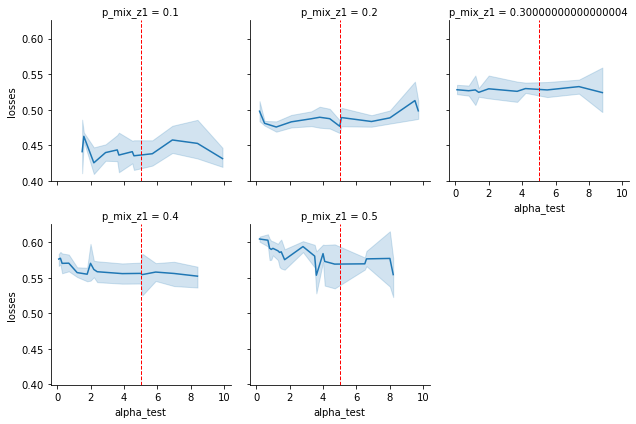

In [111]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses')

<Figure size 864x720 with 0 Axes>

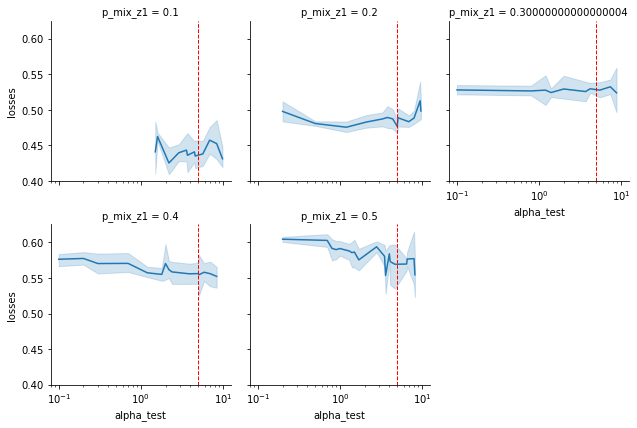

In [28]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses', logx=True)

<Figure size 864x720 with 0 Axes>

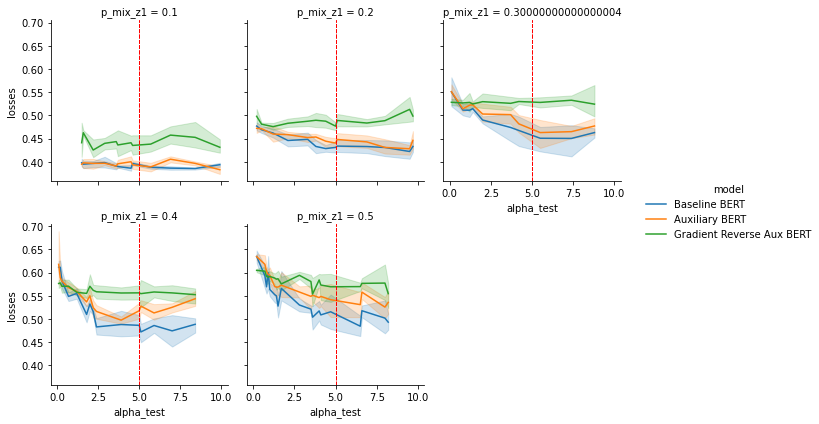

In [31]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='losses', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

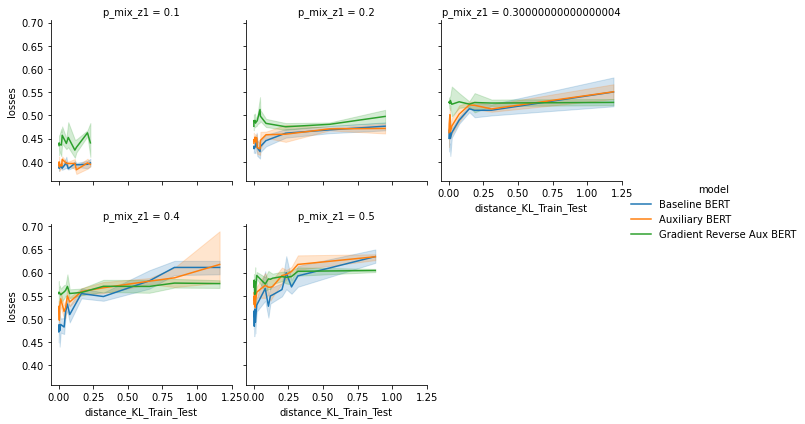

In [508]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      x="distance_KL_Train_Test",
                      key_metric='losses', alpha_train=None)

<Figure size 864x720 with 0 Axes>

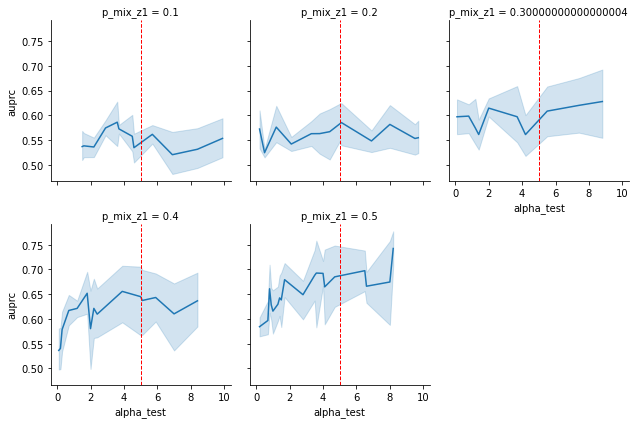

In [33]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc')

<Figure size 864x720 with 0 Axes>

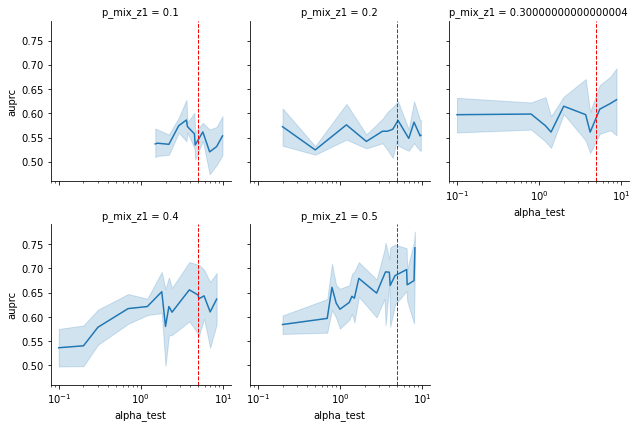

In [34]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc', logx=True)

<Figure size 864x720 with 0 Axes>

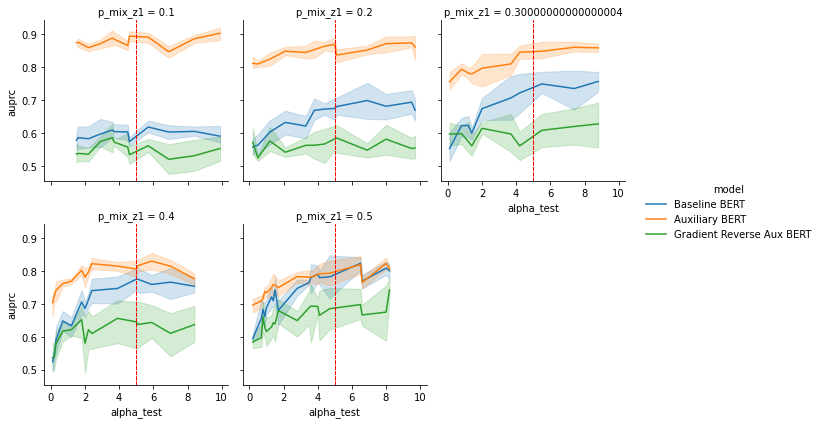

In [35]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auprc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

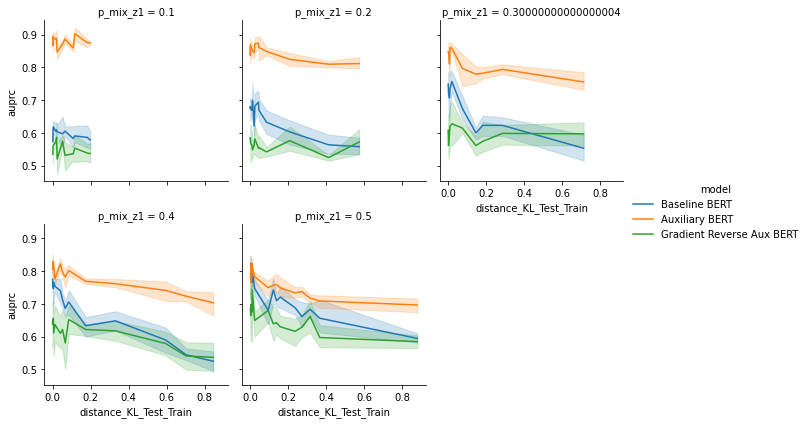

In [248]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      x="distance_KL_Test_Train",
                      key_metric='auprc', alpha_train=None)

<Figure size 864x720 with 0 Axes>

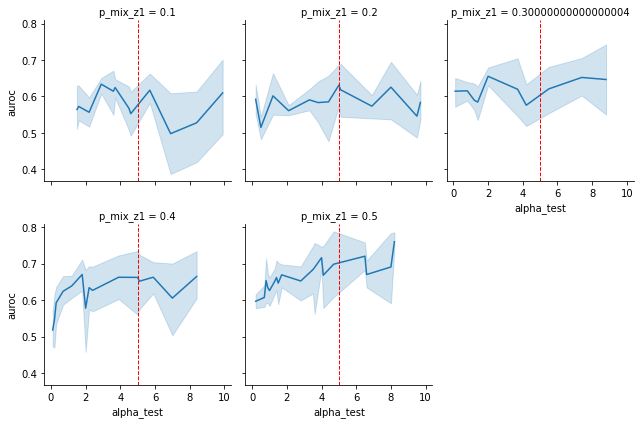

In [36]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc')

<Figure size 864x720 with 0 Axes>

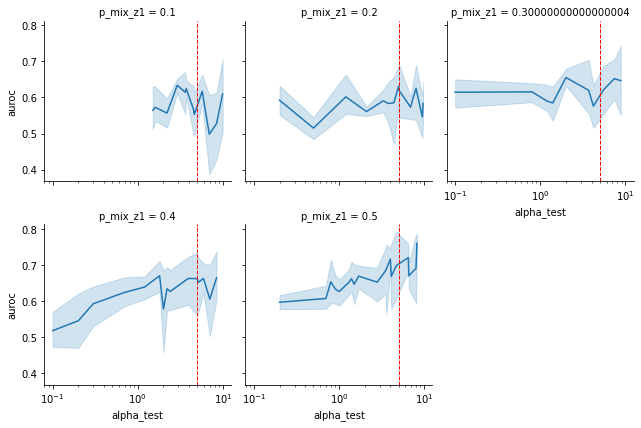

In [37]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc', logx=True)

<Figure size 864x720 with 0 Axes>

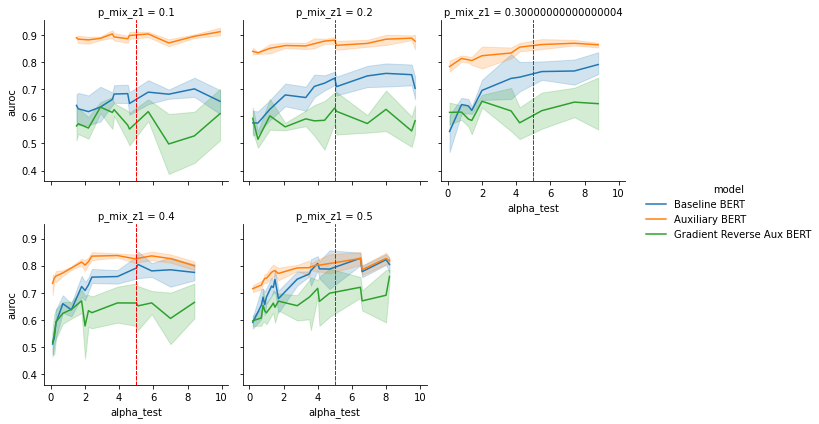

In [39]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auroc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

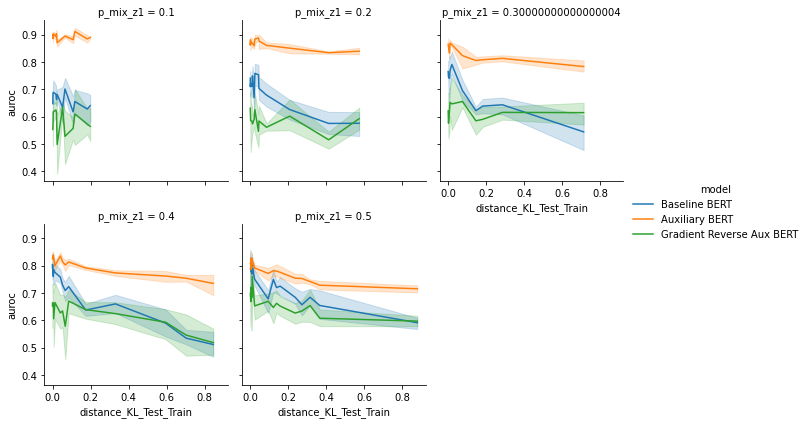

In [249]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      x="distance_KL_Test_Train",
                      key_metric='auroc', alpha_train=None)

<Figure size 864x720 with 0 Axes>

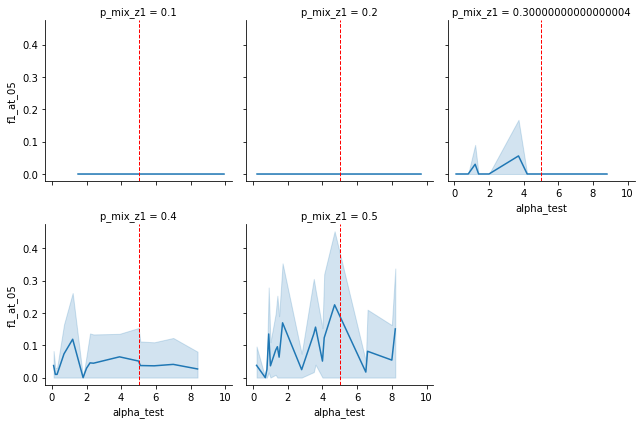

In [40]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05')

<Figure size 864x720 with 0 Axes>

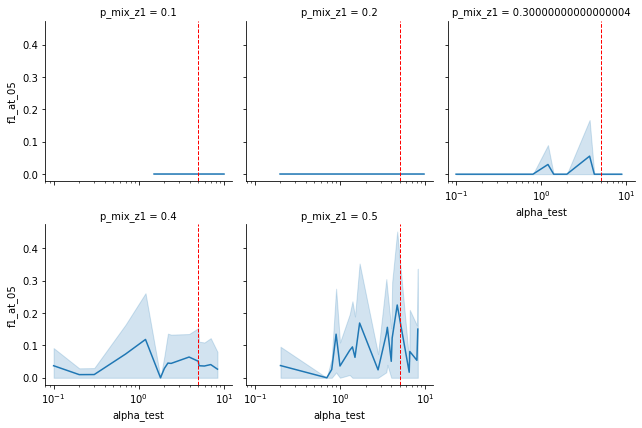

In [41]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05', logx=True)

<Figure size 864x720 with 0 Axes>

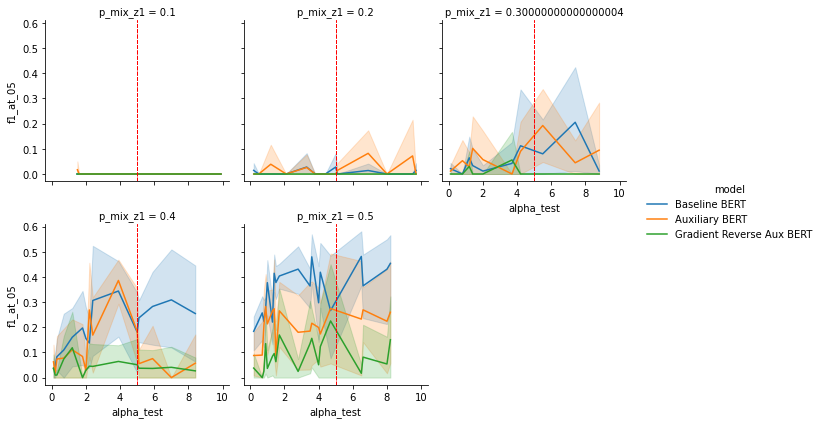

In [42]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='f1_at_05', alpha_train=alpha_train)

### Setting 1: 0.2 vs 0.4

In [250]:
alpha_train = 2
idx = 1

idx_2 = 1
idx_3 = 1

In [44]:
losses_ls[idx].keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [45]:
losses_ls[idx]['combination'][:2]

[(0.2, 0.4, 0.1, 0.4, 4, 150, 0),
 (0.2, 0.4, 0.1, 0.7000000000000001, 4, 150, 0)]

<Figure size 864x720 with 0 Axes>

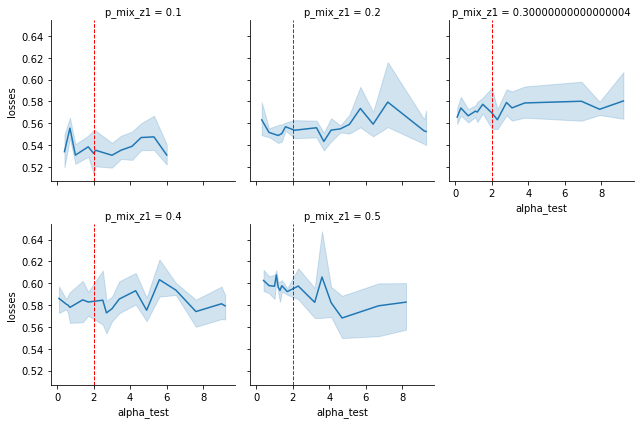

In [46]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses')

<Figure size 864x720 with 0 Axes>

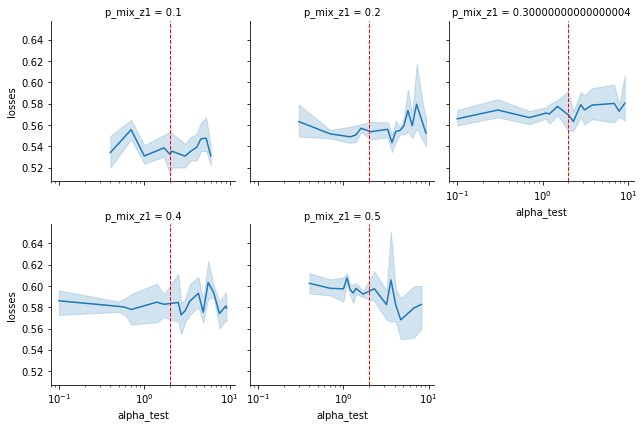

In [47]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses', logx=True)

<Figure size 864x720 with 0 Axes>

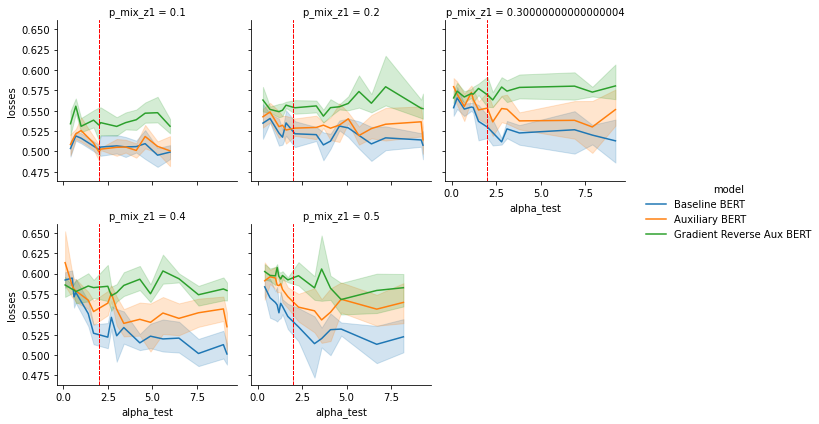

In [251]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='losses', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

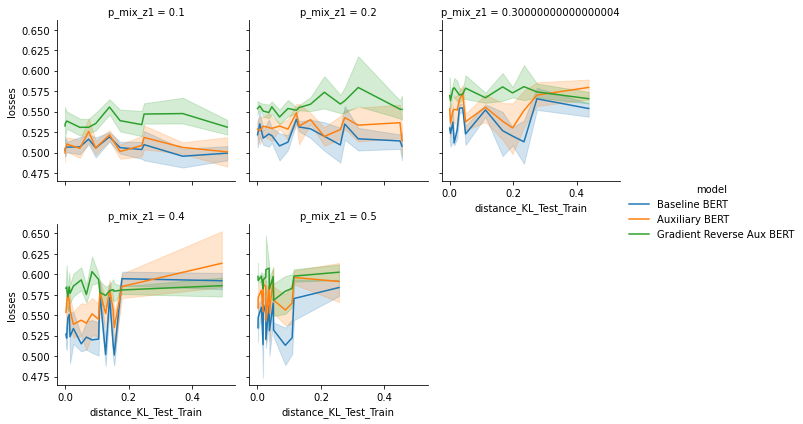

In [253]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      x="distance_KL_Test_Train",
                      key_metric='losses', alpha_train=None)

<Figure size 864x720 with 0 Axes>

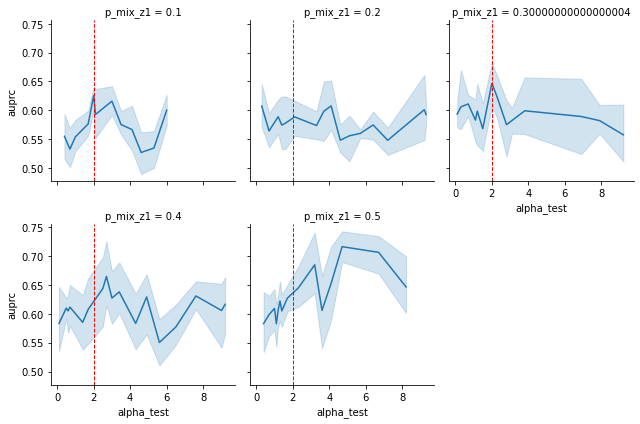

In [49]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc')

<Figure size 864x720 with 0 Axes>

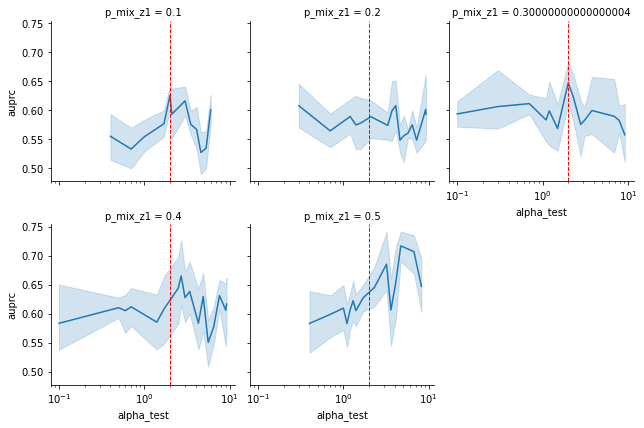

In [50]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc', logx=True)

<Figure size 864x720 with 0 Axes>

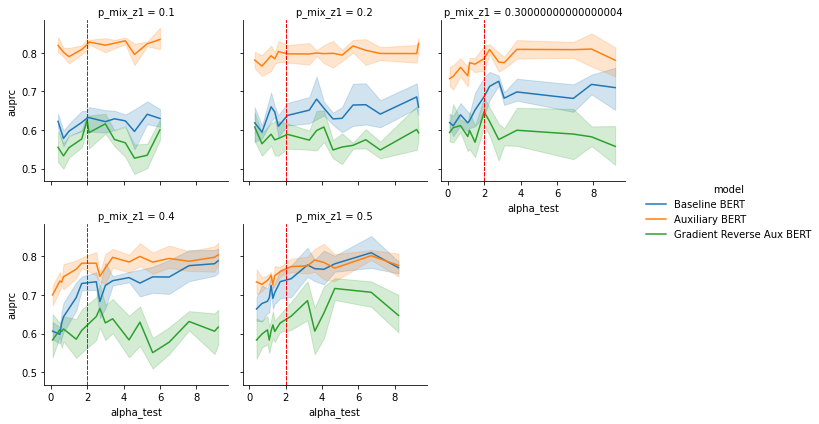

In [56]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auprc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

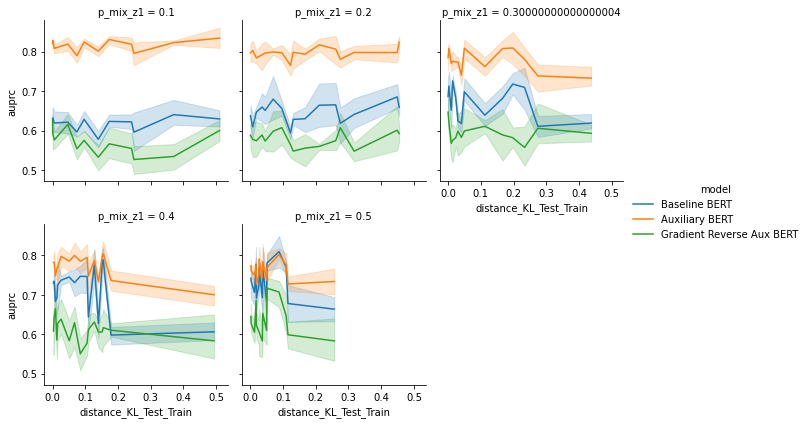

In [254]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                       x="distance_KL_Test_Train",
                      key_metric='auprc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

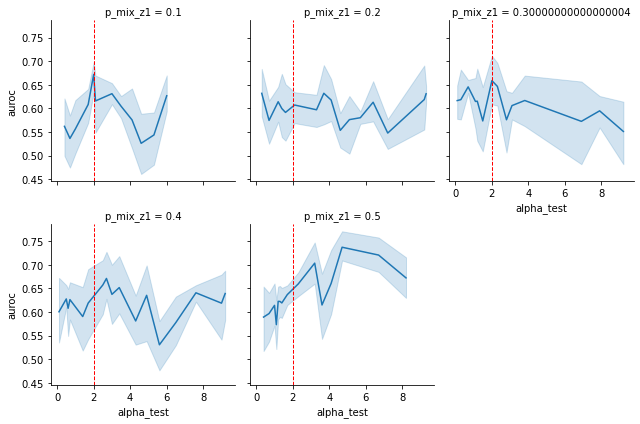

In [53]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc')

<Figure size 864x720 with 0 Axes>

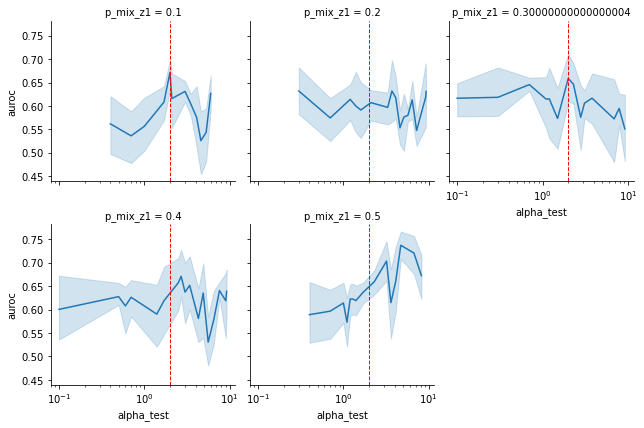

In [54]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc', logx=True)

<Figure size 864x720 with 0 Axes>

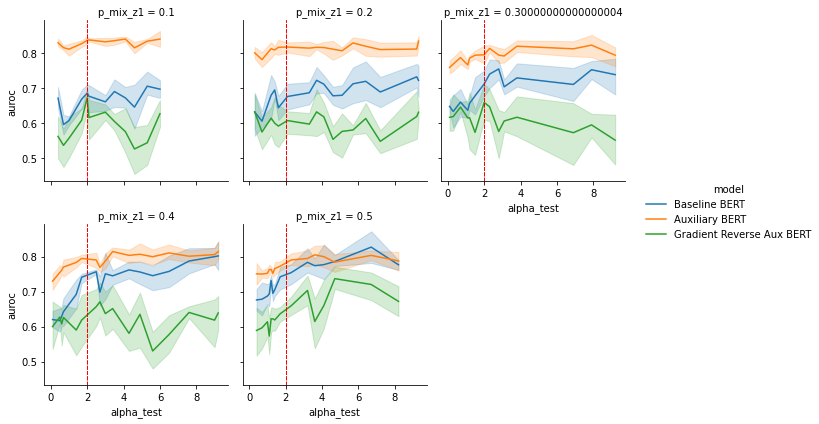

In [55]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auroc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

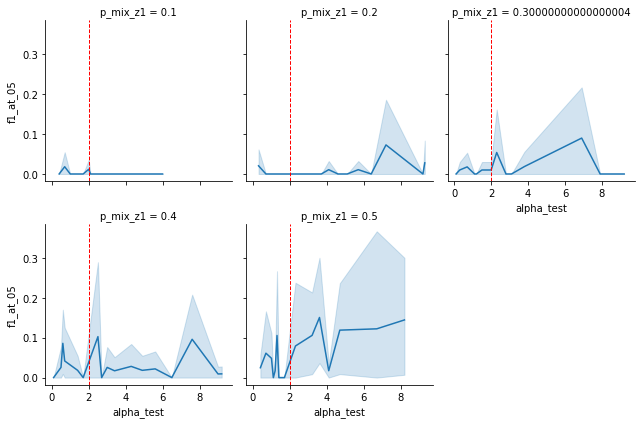

In [57]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05')

<Figure size 864x720 with 0 Axes>

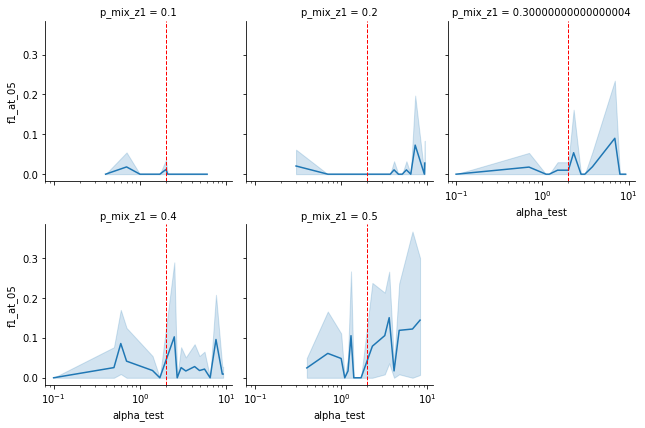

In [58]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05', logx=True)

<Figure size 864x720 with 0 Axes>

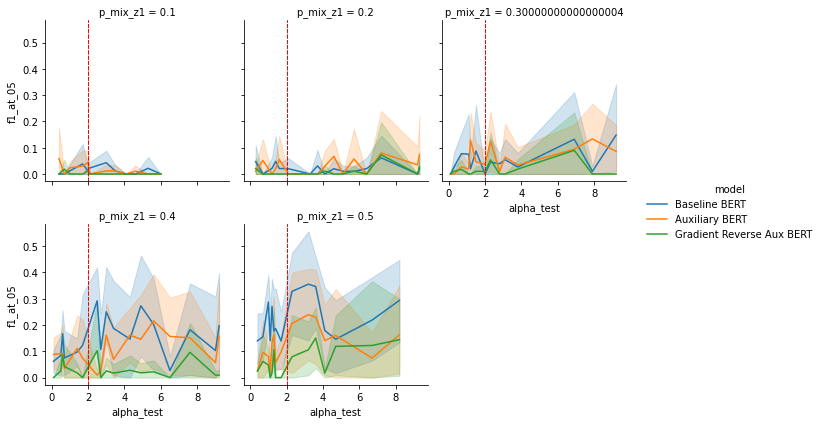

In [59]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='f1_at_05', alpha_train=alpha_train)

In [ ]:
tmp = plotAlphaDiffPmix(losses=losses_ls[1], alpha_diff_train=0.2, key_metric="auroc")

In [ ]:
tmp.query("(variable == 0) and (alpha_test == 3)")

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))


sns.scatterplot(x="alpha_test", y="p_pos_test_z0", data=tmp[tmp['variable']==0], color="b", ax=ax, label="z0 (WLS)", alpha=0.8)
sns.scatterplot(x="alpha_test", y="p_pos_test_z1", data=tmp[tmp['variable']==0], color="y", ax=ax, label="z1 (ADReSS)", alpha=0.8)

ax.axhline(y=0.2, c="b", ls="--", linewidth=1)
ax.axhline(y=0.4, c="y", ls="--", linewidth=1)

ax.axvline(x=2, c="r", ls="--", linewidth=1)

ax.set_ylabel("p_pos_test")

### Setting 3: 0.3 vs 0.6

In [60]:
alpha_train = 2
idx = 3

idx_2 = 2
idx_3 = 3

In [61]:
losses_ls[idx].keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [62]:
losses_ls[idx]['combination'][:2]

[(0.3, 0.6, 0.2, 1.4000000000000001, 4, 150, 0),
 (0.3, 0.6, 0.2, 1.6, 4, 150, 0)]

<Figure size 864x720 with 0 Axes>

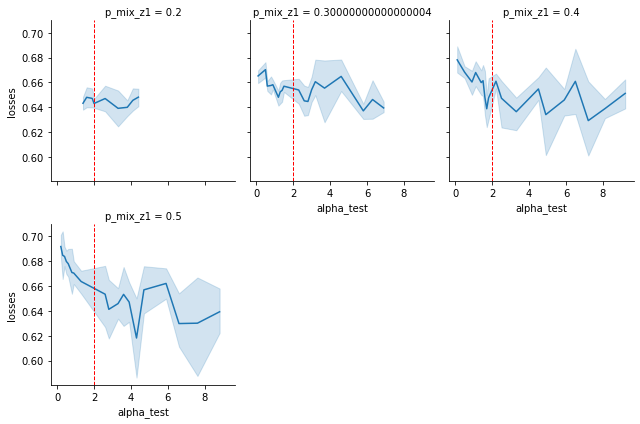

In [63]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses')

<Figure size 864x720 with 0 Axes>

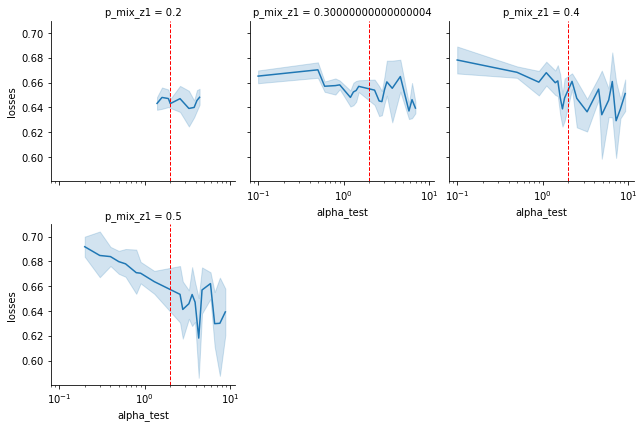

In [64]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses', logx=True)

<Figure size 864x720 with 0 Axes>

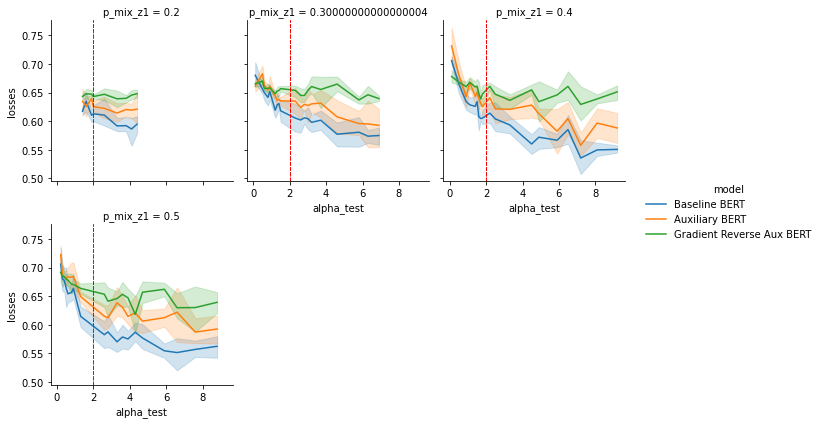

In [65]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='losses', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

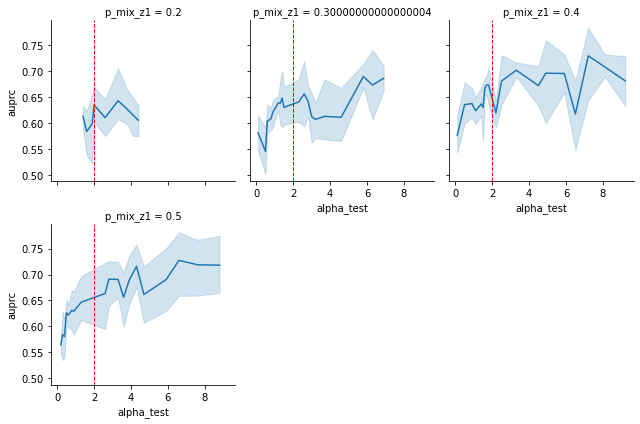

In [66]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc')

<Figure size 864x720 with 0 Axes>

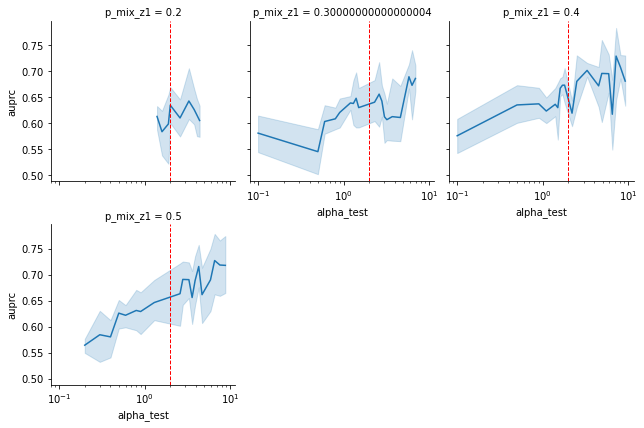

In [67]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc', logx=True)

<Figure size 864x720 with 0 Axes>

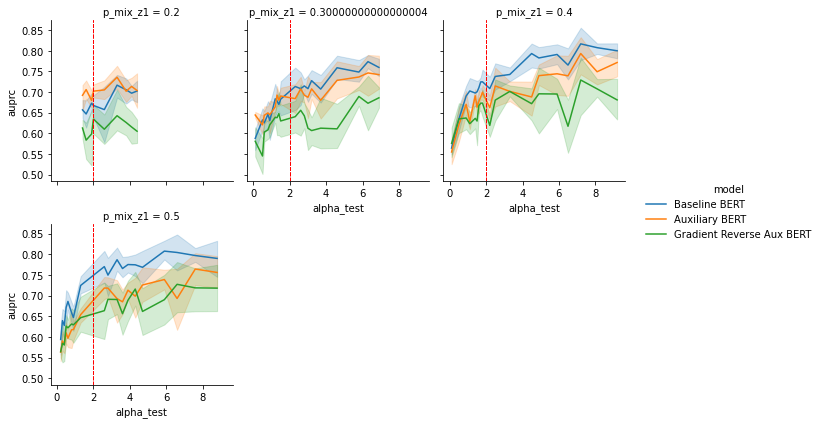

In [68]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auprc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

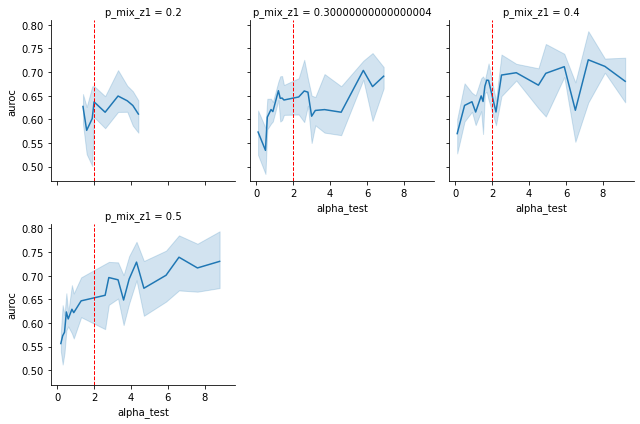

In [69]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc')

<Figure size 864x720 with 0 Axes>

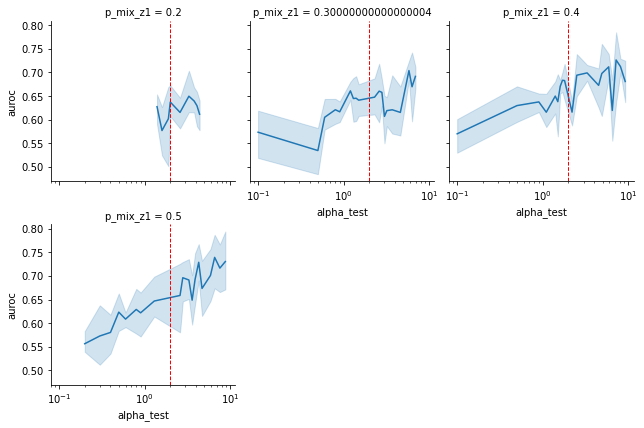

In [70]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc', logx=True)

<Figure size 864x720 with 0 Axes>

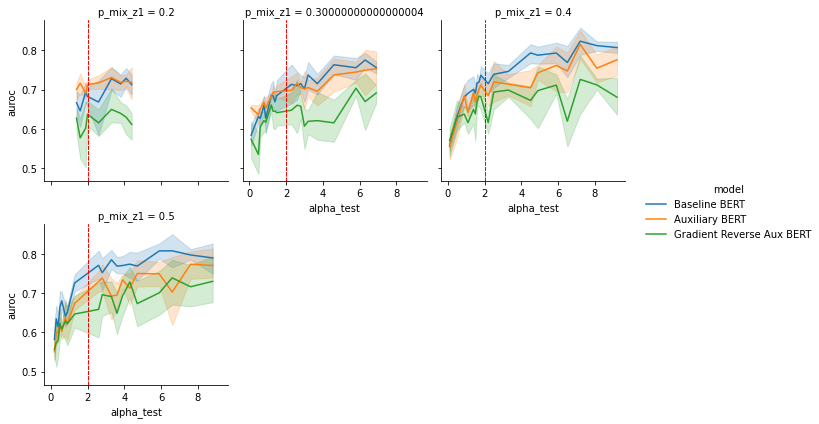

In [71]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auroc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

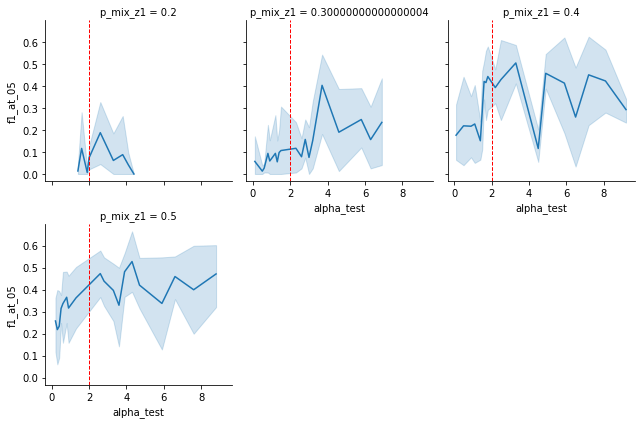

In [72]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05')

<Figure size 864x720 with 0 Axes>

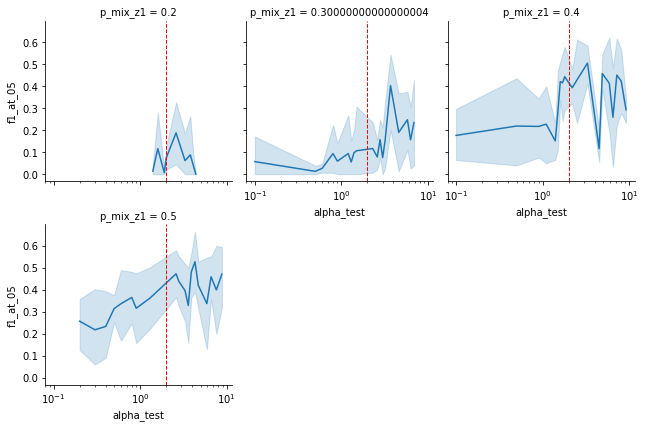

In [73]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05', logx=True)

<Figure size 864x720 with 0 Axes>

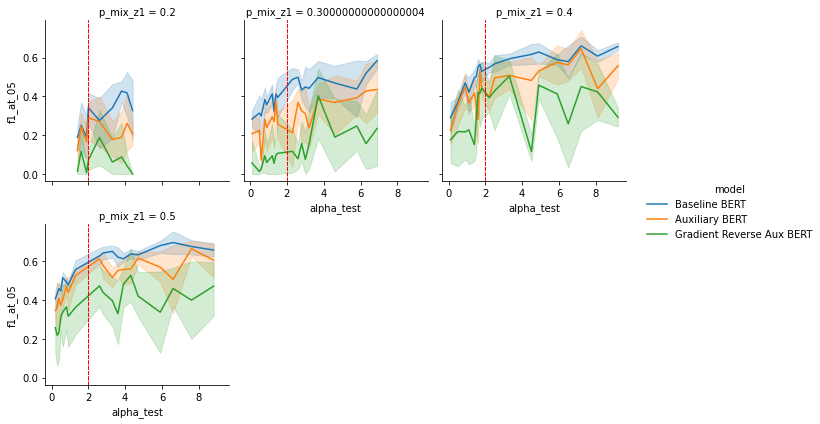

In [74]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='f1_at_05', alpha_train=alpha_train)

### Setting 2: 0.2 vs 0.6

In [75]:
alpha_train = 3
idx = 2

idx_2 = None
idx_3 = 2

In [76]:
losses_ls[idx].keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [77]:
losses_ls[idx]['combination'][:2]

[(0.2, 0.6, 0.1, 0.9, 4, 150, 0),
 (0.2, 0.6, 0.1, 1.2000000000000002, 4, 150, 0)]

<Figure size 864x720 with 0 Axes>

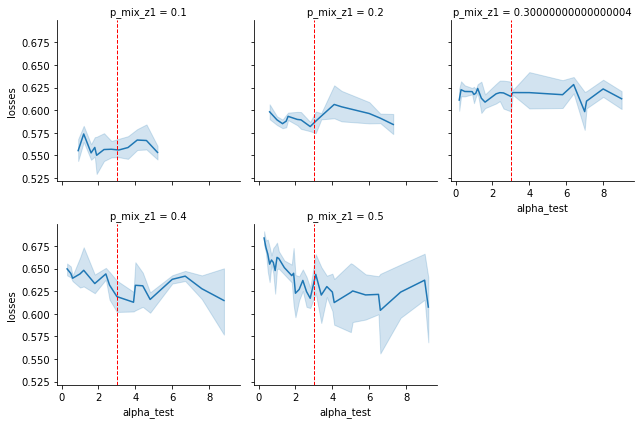

In [78]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses')

<Figure size 864x720 with 0 Axes>

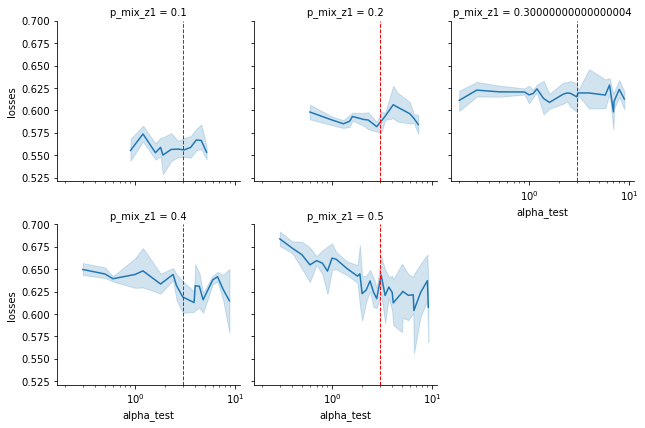

In [79]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses', logx=True)

<Figure size 864x720 with 0 Axes>

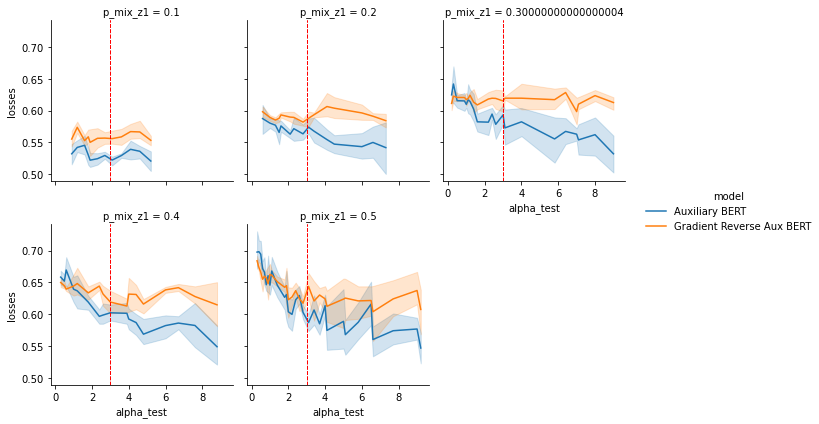

In [84]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='losses', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

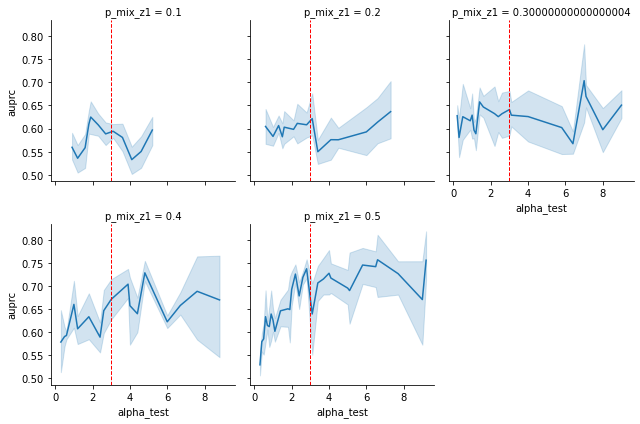

In [85]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc')

<Figure size 864x720 with 0 Axes>

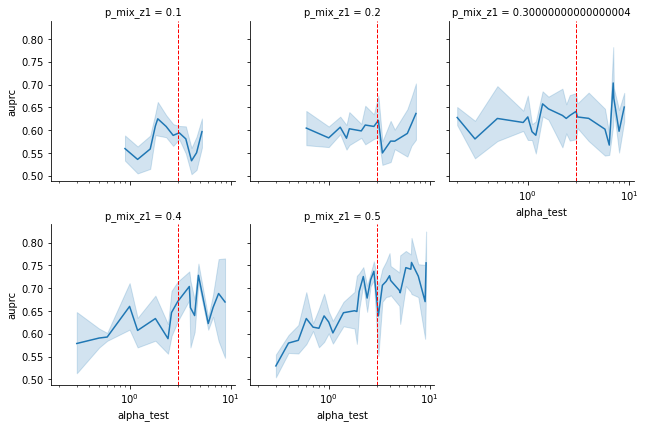

In [86]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc', logx=True)

<Figure size 864x720 with 0 Axes>

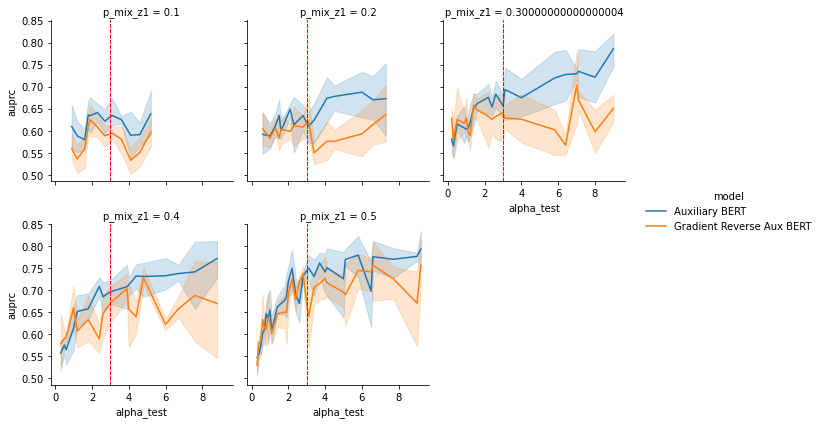

In [87]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auprc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

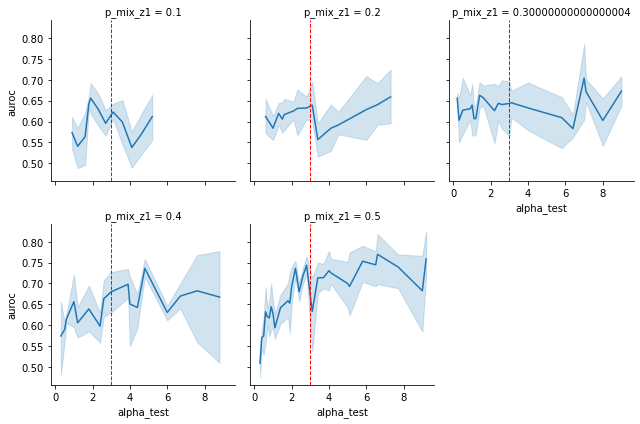

In [88]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc')

<Figure size 864x720 with 0 Axes>

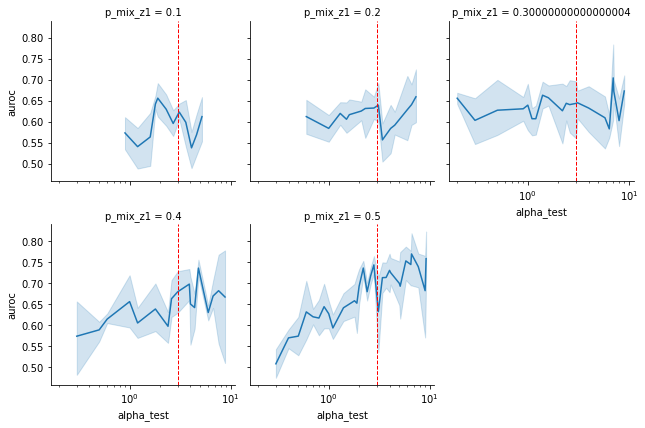

In [89]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc', logx=True)

<Figure size 864x720 with 0 Axes>

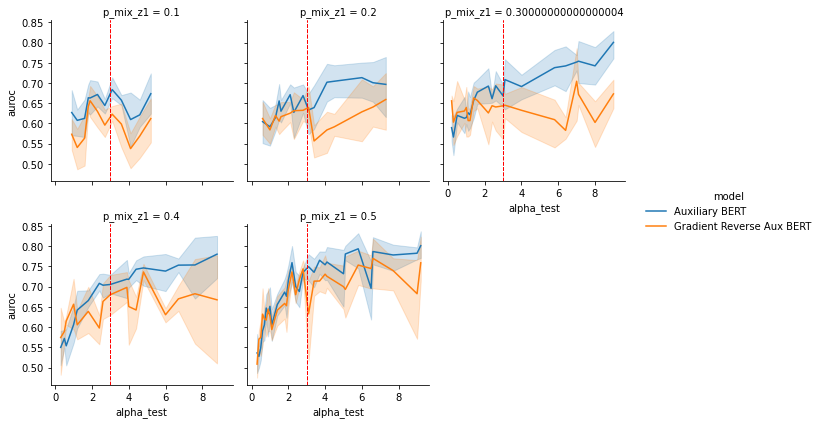

In [90]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auroc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

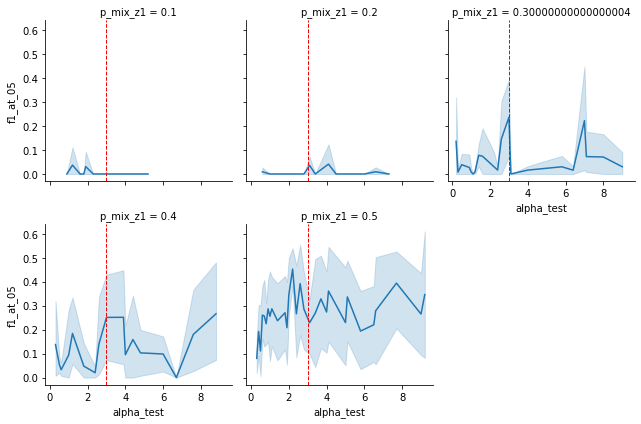

In [91]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05')

<Figure size 864x720 with 0 Axes>

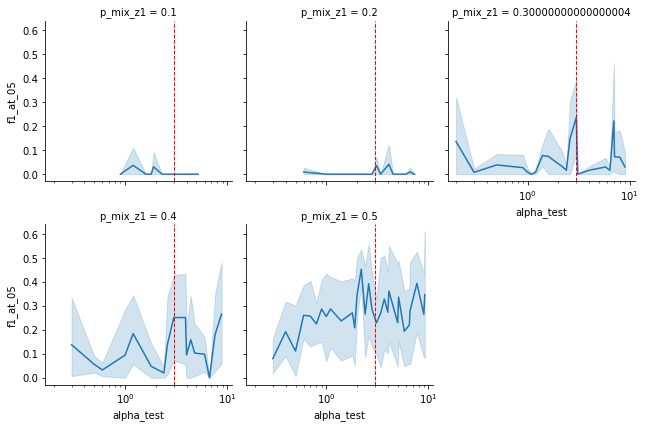

In [92]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05', logx=True)

<Figure size 864x720 with 0 Axes>

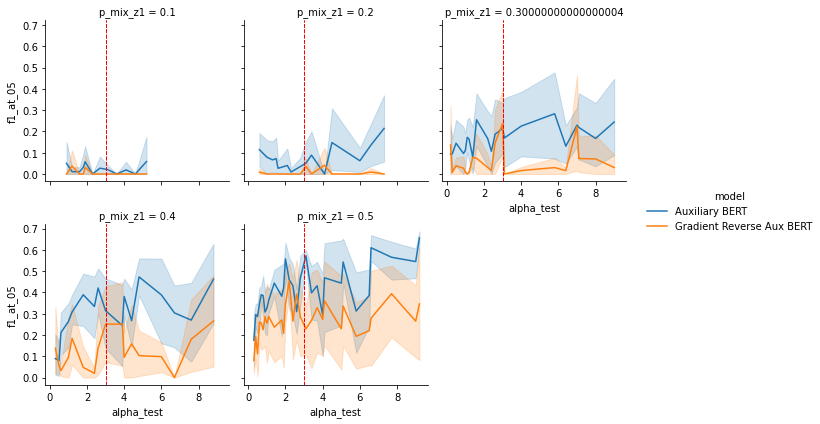

In [93]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='f1_at_05', alpha_train=alpha_train)

### Setting 4: 0.5 vs 0.3

In [94]:
alpha_train = 0.6
idx = 5

idx_2 = 3
idx_3 = 4

In [95]:
losses_ls[idx].keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [96]:
losses_ls[idx]['combination'][:2]

[(0.5, 0.3, 0.4, 1.7000000000000002, 4, 150, 20),
 (0.5, 0.3, 0.4, 1.85, 4, 150, 20)]

<Figure size 864x720 with 0 Axes>

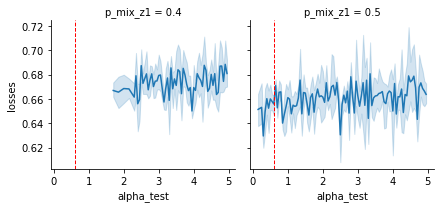

In [97]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses')

<Figure size 864x720 with 0 Axes>

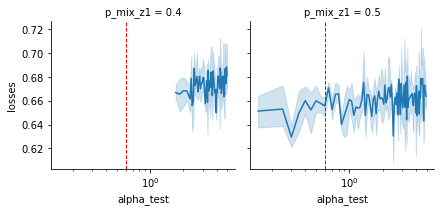

In [98]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses', logx=True)

<Figure size 864x720 with 0 Axes>

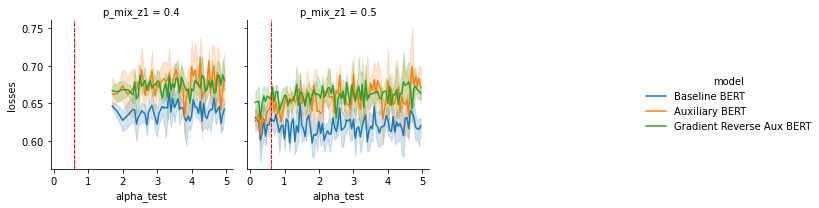

In [99]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='losses', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

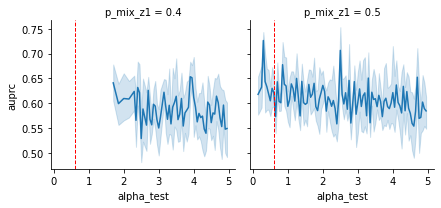

In [100]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc')

<Figure size 864x720 with 0 Axes>

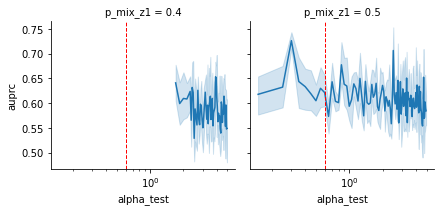

In [101]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auprc', logx=True)

<Figure size 864x720 with 0 Axes>

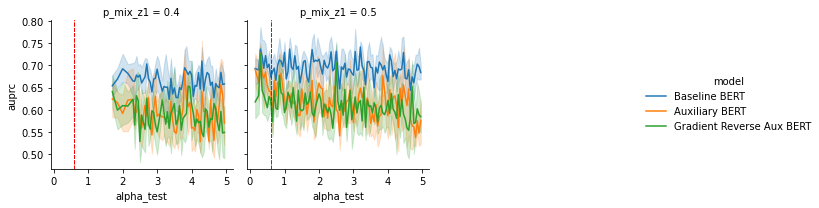

In [102]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auprc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

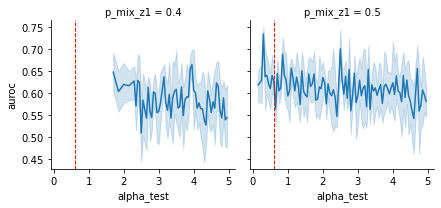

In [103]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc')

<Figure size 864x720 with 0 Axes>

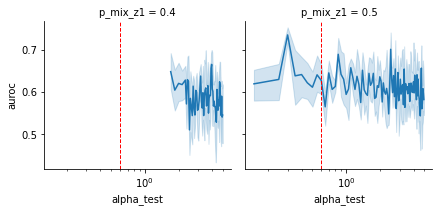

In [104]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='auroc', logx=True)

<Figure size 864x720 with 0 Axes>

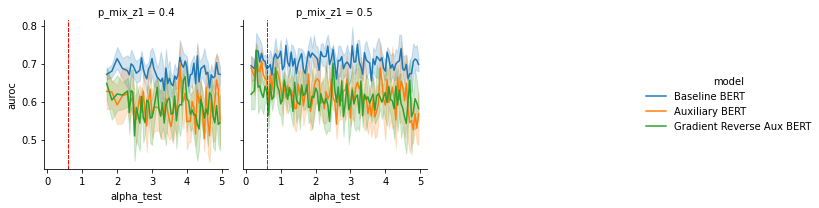

In [105]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='auroc', alpha_train=alpha_train)

<Figure size 864x720 with 0 Axes>

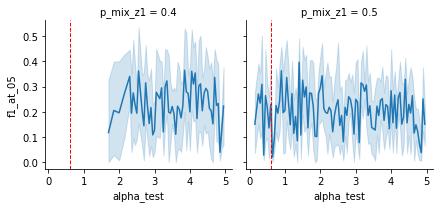

In [106]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05')

<Figure size 864x720 with 0 Axes>

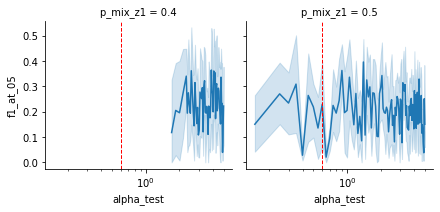

In [107]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='f1_at_05', logx=True)

<Figure size 864x720 with 0 Axes>

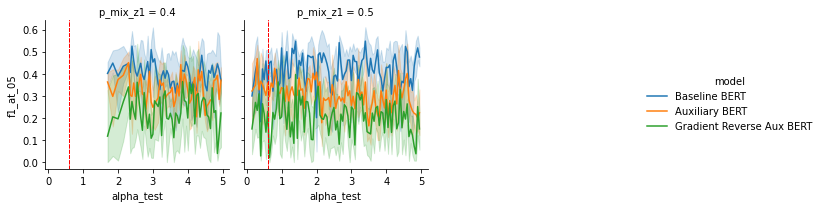

In [108]:
plotMultipleAlphaPmix(losses_in_ls=[losses_ls_single[idx_2], losses_ls_Aux[idx_3], losses_ls[idx], ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
                      key_metric='f1_at_05', alpha_train=alpha_train)

### Setting 5: 0.5 vs 0.1

In [109]:
alpha_train = 0.2
idx = 4

idx_2 = None
idx_3 = None

In [110]:
losses_ls[idx].keys()

dict_keys(['combination', 'full_setting', 'losses', 'auroc', 'auprc', 'f1_at_05'])

In [111]:
losses_ls[idx]['combination'][:2]

[(0.5, 0.1, 0.4, 2.0, 4, 150, 15), (0.5, 0.1, 0.4, 2.2, 4, 150, 15)]

<Figure size 864x720 with 0 Axes>

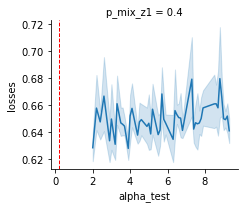

In [112]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses')

<Figure size 864x720 with 0 Axes>

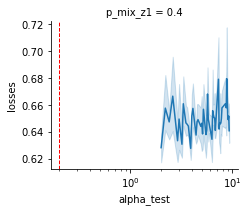

In [113]:
tmp = plotAlphaPmix(losses=losses_ls[idx], alpha_train=alpha_train, key_metric='losses', logx=True)

# tmp...

In [282]:
def ttt(losses_in_ls:[], 
                          modelName_ls:[],
                          key_metric, 
                          alpha_train=None, 
                          x='alpha_test'
                         ):
    
    df_ls = []
    
    for _loss, _mName in zip(losses_in_ls, modelName_ls):
        for _loss_single in _loss:
            
            
            _df_single = reformatLossDF(losses=_loss_single, key_metric=key_metric)
            _df_single['model'] = _mName
        
            df_ls.append(_df_single)
   

    
    
   

    tmp = pd.concat(df_ls)
    tmp.reset_index(drop=True, inplace=True)
    
    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3, hue="model")

    g.map_dataframe(sns.lineplot, x=x, y="value")
    g.add_legend()
    
    if x in ['alpha_test']:
        g.map(plt.axvline, x=alpha_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)

    return tmp

<Figure size 1080x1080 with 0 Axes>

<Figure size 864x720 with 0 Axes>

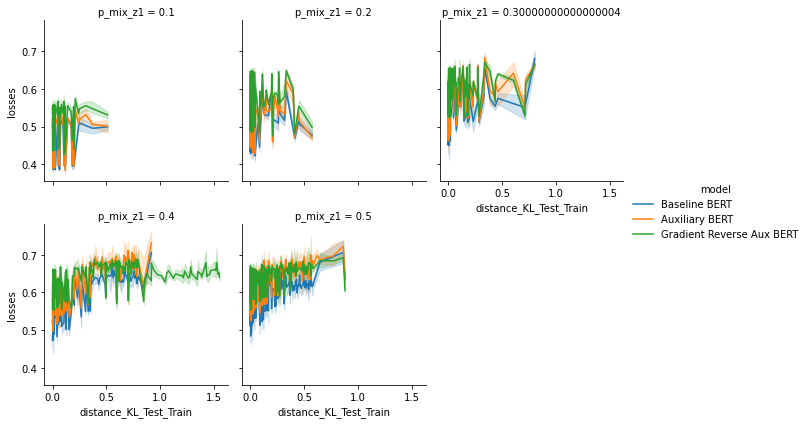

In [284]:
plt.figure(figsize=(15,15))

tmp = ttt(losses_in_ls=[losses_ls_single, losses_ls_Aux, losses_ls, ], 
                      modelName_ls=['Baseline BERT', 'Auxiliary BERT','Gradient Reverse Aux BERT'],
    x="distance_KL_Test_Train",
                      key_metric='losses', alpha_train=None)